# Topic Modelling

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import spacy
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

import re

## 2. Process data

In [2]:
df = pd.read_csv('datasets/translated_tweets.csv', index_col= False)

### 2.1 Check dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                3333 non-null   int64 
 1   date              3333 non-null   object
 2   tweet             3333 non-null   object
 3   city              3333 non-null   object
 4   retweets          3333 non-null   int64 
 5   translated_tweet  3333 non-null   object
dtypes: int64(2), object(4)
memory usage: 156.4+ KB


Check null

In [4]:
df.isna().sum()

id                  0
date                0
tweet               0
city                0
retweets            0
translated_tweet    0
dtype: int64

Check for duplicates

In [5]:
df[df.duplicated(subset='id', keep = 'first')]

,id,date,tweet,city,retweets,translated_tweet


### 2.2 Transform format for modelling

In [6]:
df_processed = df.copy()

Transform text to lowercase

In [7]:
df_processed['lower'] = df_processed['translated_tweet'].str.lower()
df_processed['lower'] = df_processed['lower'].astype(str)

Remove numbers

In [8]:
df_processed['no_num'] = [re.sub(r'\w*\d\w*','',i).strip() for i in df_processed['lower']]

In [9]:
df_processed['no_num'].tail()

3328    additional fact checks on the covid- vaccines ...
3329    sharing these frequently asked questions (faqs...
3330                this , "may the best vaccine win" 💉💉💉
3331    protect yourself and your loved ones #bevaccin...
3332    mayor marcelino teodoro and sec. vince dizon d...
Name: no_num, dtype: object

Remove punctuations

In [10]:
df_processed['no_punct'] = df_processed['no_num'].str.replace('[^ \w\s]','')

<ipython-input-10-03b6d98412da>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_processed['no_punct'] = df_processed['no_num'].str.replace('[^ \w\s]','')


In [11]:
df_processed['no_punct'].tail()

3328    additional fact checks on the covid vaccines f...
3329    sharing these frequently asked questions faqs ...
3330                      this  may the best vaccine win 
3331    protect yourself and your loved ones bevaccina...
3332    mayor marcelino teodoro and sec vince dizon du...
Name: no_punct, dtype: object

Remove stopwords

In [12]:
nlp = spacy.load('en_core_web_lg',disable=['parser', 'ner'])
stop = stopwords.words('english')

In [13]:
newStopWords = ['vaccine','vax','covid','corona', 'what', 'zeneca', 'yesterday', 'years','u','ko','dun','bobo','vaccinate','vaccination',
                'year','vaccination','vax','covidvaccine','covidvaccination','covidvax', 'covidph','coronavirus','virus',
                'vaccineph','covidcaccine','getvaccinated','sinovac','astrazeneca', 'az', 'coronovac',
                'novovax', 'sputnikv','pfizer', 'moderna', 'fda' 'resbakuna', 'vaccineswork', 'nasaanangbakuna','ar','bat',
                'astrazeneca','astra zeneca','mo','eh','sa','na','aba','pa','po','ba','ni','si','via', 'gurl','s','c,''baket',
                'yung','yun','yon','po','pong','nalang','ba','yong','ung','na','mag','kaka','pa','opo','naku','n', 'eme','ai','ka']
stop.extend(newStopWords)

In [14]:
df_processed['no_stopwords'] = df_processed['no_punct'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))

In [15]:
df_processed['no_stopwords'].tail()

3328    additional fact checks vaccines uppgh bayaniha...
3329    sharing frequently asked questions faqs pgh ba...
3330                                         may best win
3331    protect loved ones bevaccinated philippine gen...
3332    mayor marcelino teodoro sec vince dizon simula...
Name: no_stopwords, dtype: object

Tokenize

In [16]:
df_processed['tokenized'] = df_processed['no_stopwords'].apply(lambda x: nlp(x))
df_processed['tokenized'] = df_processed['tokenized'].apply(lambda x: [word.text for word in x])

In [17]:
df_processed['tokenized'].tail()

3328    [additional, fact, checks, vaccines, uppgh, ba...
3329    [sharing, frequently, asked, questions, faqs, ...
3330                                     [may, best, win]
3331    [protect, loved, ones, bevaccinated, philippin...
3332    [mayor, marcelino, teodoro, sec, vince, dizon,...
Name: tokenized, dtype: object

Combining two or three related words (bigrams or trigrams)

In [18]:
import gensim.models

In [19]:
# creating bigrams and trigrams

bigram = gensim.models.Phrases(df_processed['tokenized'], min_count=10, threshold=100) 
trigram = gensim.models.Phrases(bigram[df_processed['tokenized']], threshold=100)

In [20]:
df_processed['bigram'] = df_processed['tokenized'].apply(lambda x: bigram[x]) 
df_processed['trigram'] = df_processed['bigram'].apply(lambda x: trigram[x])

Joining all words before lemmatizing

In [21]:
df_processed['joined'] = df_processed['trigram'].apply(lambda x: ' '.join(x))

In [22]:
df_processed['joined'].tail()

3328    additional fact checks vaccines uppgh bayaniha...
3329    sharing frequently asked questions faqs pgh ba...
3330                                         may best win
3331    protect loved ones bevaccinated philippine gen...
3332    mayor marcelino teodoro sec vince_dizon simula...
Name: joined, dtype: object

Lemmatization and filtering part of speech tagging; only getting the 'NOUN','ADJ','VERB','ADV'

In [23]:
allowed_tag = ['NOUN', 'ADJ', 'VERB', 'ADV']

df_processed['joined'] = df_processed['joined'].apply(lambda x: nlp(x))
df_processed['lemmatized'] = df_processed['joined'].apply(lambda x: [word.lemma_ for word in x if word.pos_ in allowed_tag])

In [24]:
df_processed['lemmatized'] = df_processed['lemmatized'].apply(lambda words: [word for word in words if word not in stop])

In [25]:
df_processed['lemmatized'].tail()

3328          [additional, fact, check, bayanihan, group]
3329    [share, frequently, ask, question, faqs, pgh, ...
3330                                          [well, win]
3331        [protect, love, one, bevaccinate, philippine]
3332    [mayor, marcelino, sec, vince_dizon, simulatio...
Name: lemmatized, dtype: object

Ensure that only english words are included

In [26]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to /Users/macbook/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [27]:
words = set(nltk.corpus.words.words())

In [28]:
df_processed['no_foreign'] = df_processed['lemmatized'].apply(lambda x: [w for w in x if w in words])

In [29]:
df_processed['no_foreign'].tail()

3328                     [additional, fact, check, group]
3329            [share, frequently, ask, question, group]
3330                                          [well, win]
3331                                 [protect, love, one]
3332    [mayor, sec, simulation, exercise, facility, m...
Name: no_foreign, dtype: object

Collect IDs of rows with zero length for 'no_foreign' column

In [30]:
df_processed.reset_index(inplace=True)
df_processed.drop('index', axis=1, inplace=True)

In [31]:
zero_len = []

for i in range(0,len(df_processed.id)):
    if len(df_processed['no_foreign'][i]) == 0:
        zero_len.append(df_processed['id'][i])
        

Filter out those rows

In [32]:
df_processed = df_processed[~df_processed.id.isin(zero_len)]
df_processed.shape

(3255, 16)

In [155]:
#df_processed.to_csv("datasets/tweets_processed.csv",index=None)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Create dictionary and corpus
- Dictionary() implements the concept of a Dictionary – a mapping between words and their integer ids.
- **doc2bow** - Converts document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples. Each word is assumed to be a tokenized and normalized string (either unicode or utf8-encoded)

In [33]:
from gensim.corpora import Dictionary

In [34]:
dictionary = Dictionary(df_processed['no_foreign'])

In [35]:
corpus =[dictionary.doc2bow(word) for word in df_processed['no_foreign']]

# 2. Topic Modelling

In [36]:
import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
import pyLDAvis.gensim

## 2.2 Latent Semantic Index (LSI)

LSA (Latent Semantic Analysis) also known as LSI (Latent Semantic Index) LSA uses bag of word(BoW) model, which results in a term-document matrix(occurrence of terms in a document). Rows represent terms and columns represent documents. LSA learns latent topics by performing a matrix decomposition on the document-term matrix using Singular value decomposition. LSA is typically used as a dimension reduction or noise reducing technique. *Source: https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python*

In [43]:
def compute_coherence_values_lsi(dictionary, corpus, doc_clean, stop, start, step):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(corpus=corpus, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
def plot_graph(model_list,coherence_values,start, stop, step):
    model_list = model_list
    coherence_values = coherence_values
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Get LSI models and coherence values from 5 to 12 topics

In [48]:
import random
random.seed(42)

texts = df_processed['no_foreign']
start,stop,step=5,12,1
lsi_model_list, lsi_coherence_values = compute_coherence_values_lsi(dictionary, corpus,texts,stop, start, step)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Plot coherence scores

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


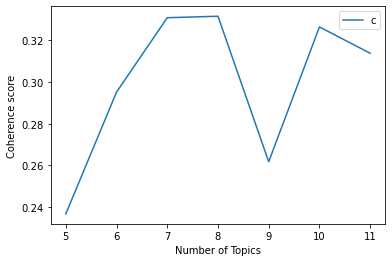

In [49]:
plot_graph(lsi_model_list ,lsi_coherence_values, start, stop, step)

The number of topics before the graph plateaud is 7 so let's choose 7.

In [54]:
lsi_model = lsi_model_list[2]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
lsi_coherence_value = lsi_coherence_values[2]
lsi_coherence_value

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.33073577810224347

## 2.2 Latent Dirichlet Allocation (LDA)

LDA is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.
- Each document is modeled as a multinomial distribution of topics and each topic is modeled as a multinomial distribution of words.
- LDA assumes that the every chunk of text we feed into it will contain words that are somehow related. Therefore choosing the right corpus of data is crucial.
- It also assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution.

*Source: https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925*

In [59]:
def compute_coherence_values_lda(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,random_state=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Get LDA models and coherence values from 5 to 12 topics

In [60]:
start,stop,step=5,12,1
lda_model_list, lda_coherence_values = compute_coherence_values_lda(dictionary, corpus,texts,stop, start, step)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Plot coherence scores

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


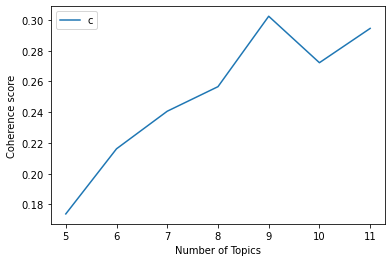

In [61]:
plot_graph(lda_model_list, lda_coherence_values, start, stop, step)

The LDA model with 9 topics has the highest coherence score so let's choose 9.

In [62]:
lda_model = lda_model_list[4]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
lda_coherence_value = lda_coherence_values[4]
lda_coherence_value

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.30241589669530866

## 2.3 Hierarchical Dirichlet Process (HDP)

HDP is a nonparametric Bayesian approach to clustering grouped data. It uses a Dirichlet process for each group of data, with the Dirichlet processes for all groups sharing a base distribution which is itself drawn from a Dirichlet process. *Source: https://en.wikipedia.org/wiki/Hierarchical_Dirichlet_process*

In [153]:
hdpmodel = HdpModel(corpus=corpus,id2word=dictionary, random_state=4244)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [154]:
hdp_coherence = CoherenceModel(model=hdpmodel,
                             texts=texts,
                             dictionary=dictionary).get_coherence()
hdp_coherence

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0.7639231930823178

**Why not HDP if it has a high coherence score?**

HDP is supposed to give the number of optimal topics, but in gensim (python library used for LSI, LDA, and HDP) it automatically creates 150 topics. [This thread from stackoverflow](https://stackoverflow.com/questions/31543542/hierarchical-dirichlet-process-gensim-topic-number-independent-of-corpus-size) mentions a technique of looking at the alpha vector of topics but it wasn’t specified how to use the alpha vector to determine the optimal number of topics. [There’s this other thread](https://gensim.narkive.com/CsjEw3ob/gensim-9520-having-hdp-ldp-determine-number-of-topics) asking the same thing but no answer was given.

Since gensim’s HDP is too complex to use (at least for our current level of expertise or the lack of it), LDA Mallet was chosen instead. But there’s an [article from Towards Data Science](https://towardsdatascience.com/dont-be-afraid-of-nonparametric-topic-models-part-2-python-e5666db347a) mentioning another Python library (tomotopy) that can be used for HDP, that’s something that could be explored in the future.

## 2.4 LDA Mallet

Mallet, an open source toolkit, was written by Andrew McCullum. It is basically a Java based package which is used for NLP, document classification, clustering, topic modeling, and many other machine learning applications to text. It provides us the Mallet Topic Modeling toolkit which contains efficient, sampling-based implementations of LDA as well as Hierarchical LDA. 

Python provides Gensim wrapper for Latent Dirichlet Allocation (LDA). The syntax of that wrapper is gensim.models.wrappers.LdaMallet. This module, collapsed gibbs sampling from MALLET, allows LDA model estimation from a training corpus and inference of topic distribution on new, unseen documents as well.

Download Mallet file here: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

In [64]:
import os
os.environ.update({'MALLET_HOME':r'*/mallet-2.0.8'}) 
mallet_path = 'mallet-2.0.8/bin/mallet'


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
def compute_coherence_values_lda_mallet(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary,random_seed=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Get LDA Mallet models and coherence values from 5 to 12 topics

In [67]:
start,stop,step=5,12,1
mallet_model_list, mallet_coherence_values = compute_coherence_values_lda_mallet(dictionary, corpus,texts,stop, start, step)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Plot coherence scores

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


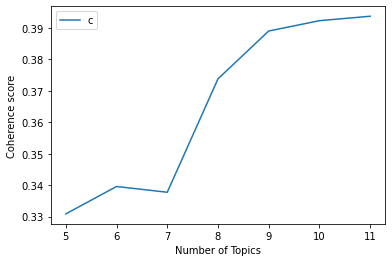

In [68]:
plot_graph(mallet_model_list, mallet_coherence_values, start, stop, step)

Take 10 as the number of topics

In [69]:
lda_mallet = mallet_model_list[5]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
mallet_coherence_score = mallet_coherence_values[5]
mallet_coherence_score

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.39223001767879034

Convert LDA Mallet to LDA before visualizing through pyLDAvis

In [74]:
def ldaMalletConvertToldaGen(mallet_model):
    model_gensim = LdaModel(id2word=mallet_model.id2word, num_topics=mallet_model.num_topics, alpha=mallet_model.alpha, eta=0, gamma_threshold=0.001, dtype=np.float32)
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

ldamallet_model = ldaMalletConvertToldaGen(lda_mallet)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamallet_model, corpus, dictionary, R = 10,sort_topics=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.080831 -0.221243       1        1  10.104816
3     -0.067813  0.106645       2        1  10.101583
6      0.285923 -0.122207       3        1  10.056950
5     -0.056306  0.231731       4        1  10.029048
9      0.274687 -0.011225       5        1   9.987606
1     -0.096195 -0.154465       6        1   9.969889
4     -0.035361  0.029146       7        1   9.955657
0     -0.243579 -0.098471       8        1   9.947008
7      0.008852 -0.032452       9        1   9.937374
2      0.010624  0.272542      10        1   9.910069, topic_info=           Term        Freq       Total Category  logprob  loglift
37   government  324.000000  324.000000  Default  10.0000  10.0000
352      people  307.000000  307.000000  Default   9.0000   9.0000
26         give  269.000000  269.000000  Default   8.0000   8.0000
108     country  258.000000  258.000000  Default   7.0000   7.0000
8          good  228.000000  228.000000  Default   6.0000   6.0000
..          ...         ...         ...      ...      ...      ...
372      supply   54.358955   54.358955  Topic10  -3.9570   2.3116
775        deal   54.358955   54.358955  Topic10  -3.9570   2.3116
366     arrival   51.830631   51.830631  Topic10  -4.0047   2.3116
335    approval  128.944496  130.168479  Topic10  -3.0933   2.3022
973       march   46.773981   48.019474  Topic10  -4.1073   2.2853

[206 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
24        7  0.986458     agree
32        5  1.005544     angry
167       8  1.019520    animal
118       4  0.967075     annoy
335       5  0.007682  approval
...     ...       ...       ...
63        3  0.962821      wait
63        5  0.015784      wait
63       10  0.023676      wait
23        1  0.995956      work
517       3  1.005815     world

[228 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 4, 7, 6, 10, 2, 5, 1, 8, 3])

Save pyLDAvis as an html (optional)

In [63]:
p = pyLDAvis.gensim.prepare(ldamallet_model, corpus, dictionary, R = 10)
pyLDAvis.save_html(p,'ldamallet.html')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###  2.4.1 Getting documents from the model

Assigning topics to tweets.

*Source: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/?fbclid=IwAR3WeOhcFZNPaeiqRu23qhVWms6ogHB3gA7YsJaDKT0XD5IlkudaVP-8Bz8#2prerequisitesdownloadnltkstopwordsandspacymodelforlemmatization*

In [105]:
sent_topics_df = pd.DataFrame()

    # Get main topic in each document
for i, row in enumerate(ldamallet_model[corpus]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:  # => dominant topic
            wp = ldamallet_model.show_topic(topic_num, topn=10)
            topic_keywords = ", ".join([word for word, prop in wp])
            sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
        else:
            break
        
sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [106]:
sent_topics_df.head()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,9.0,0.1296,"government, make, china, national, company, or..."
1,0.0,0.1319,"give, good, hope, issue, safe, news, pandemic,..."
2,9.0,0.1111,"government, make, china, national, company, or..."
3,7.0,0.1231,"buy, arrive, smuggle, money, free, long, city,..."
4,8.0,0.1154,"time, public, work, medical, protect, launch, ..."


In [107]:
sent_topics_df.shape

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(3255, 3)

In [108]:
df_cut = df_processed[['id','tweet','retweets','translated_tweet']]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [109]:
df_cut.shape

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(3255, 4)

In [110]:
sent_topics_df.reset_index(inplace=True)
df_cut.reset_index(inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [111]:
sent_topics_df.tail()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,Dominant_Topic,Perc_Contribution,Topic_Keywords
3250,3250,7.0,0.1111,"buy, arrive, smuggle, money, free, long, city,..."
3251,3251,6.0,0.1111,"people, wait, plan, world, trust, expert, live..."
3252,3252,1.0,0.1145,"health, start, receive, expensive, today, feel..."
3253,3253,8.0,0.1154,"time, public, work, medical, protect, launch, ..."
3254,3254,7.0,0.1779,"buy, arrive, smuggle, money, free, long, city,..."


In [112]:
df_cut.tail()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,id,tweet,retweets,translated_tweet
3250,3328,1352566721417154304,additional fact checks on the covid-19 vaccine...,6,additional fact checks on the covid-19 vaccine...
3251,3329,1350723862258806784,sharing these frequently asked questions (faqs...,6,sharing these frequently asked questions (faqs...
3252,3330,1344961259217686528,"this 2021, ""may the best vaccine win"" 💉💉💉",6,"this 2021, ""may the best vaccine win"" 💉💉💉"
3253,3331,1368866497540591616,protect yourself and your loved ones #bevaccin...,6,protect yourself and your loved ones #bevaccin...
3254,3332,1356878859644383232,mayor marcelino teodoro and sec. vince dizon d...,4,mayor marcelino teodoro and sec. vince dizon d...


In [113]:
df_merged = pd.merge(df_cut, sent_topics_df, how='right', right_on='index', left_index=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [114]:
df_merged.shape

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(3255, 10)

In [115]:
df_merged.isna().sum()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


index                0
index_x              0
id                   0
tweet                0
retweets             0
translated_tweet     0
index_y              0
Dominant_Topic       0
Perc_Contribution    0
Topic_Keywords       0
dtype: int64

In [116]:
df_merged.head(3)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,index_x,id,tweet,retweets,translated_tweet,index_y,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,0,0,1348608500046340096,kaloka eh. push na push dun sa vaccine from ch...,3,crazy. they push so much for the vaccine from ...,0,9.0,0.1296,"government, make, china, national, company, or..."
1,1,1,1347059249227079680,vaccine day nla daddy ngayon sa guam sana goods,3,it's daddy's vaccine day in guam i hope everyt...,1,0.0,0.1319,"give, good, hope, issue, safe, news, pandemic,..."
2,2,2,1349389062700863488,lgu rin namin here astrazeneca yung inaeye na ...,5,our lgu here is also eyeing to procure astraze...,2,9.0,0.1111,"government, make, china, national, company, or..."


In [117]:
df_merged.drop(columns=['index','index_x','index_y'], axis=1, inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [118]:
df_merged['Dominant_Topic'] = df_merged['Dominant_Topic'].astype(int)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [119]:
list_ = []
for row in df_merged.itertuples(index=False):
    if row.retweets != 1:
        list_.extend([list(row)]*(row.retweets))
    else:
        list_.append(list(row))

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [120]:
df_retweets = pd.DataFrame(list_, columns=df_merged.columns)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [121]:
df_retweets.groupby(['Dominant_Topic','Topic_Keywords']).size()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dominant_Topic  Topic_Keywords                                                                   
0               give, good, hope, issue, safe, news, pandemic, care, move, stupid                    3020
1               health, start, receive, expensive, today, feel, early, brand, hospital, end          3210
2               dose, approval, approve, president, local, deal, supply, arrival, march, register    3628
3               efficacy, effective, case, day, high, safety, low, datum, show, result               3017
4               inject, choose, question, base, leader, priority, price, choice, cost, die           2857
5               country, program, mayor, czar, lack, focus, variant, surge, procurement, lead        2533
6               people, wait, plan, world, trust, expert, live, life, lot, doctor                    2585
7               buy, arrive, smuggle, money, free, long, city, sec, donate, big                      2672
8               time, public, work, medical, protect, 

In [137]:
df_retweets

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,tweet,retweets,translated_tweet,Dominant_Topic,Perc_Contribution,Topic_Keywords,Topic_Name
0,1348608500046340096,kaloka eh. push na push dun sa vaccine from ch...,3,crazy. they push so much for the vaccine from ...,9,0.1296,"government, make, china, national, company, or...",Vaccine arrival
1,1348608500046340096,kaloka eh. push na push dun sa vaccine from ch...,3,crazy. they push so much for the vaccine from ...,9,0.1296,"government, make, china, national, company, or...",Vaccine arrival
2,1348608500046340096,kaloka eh. push na push dun sa vaccine from ch...,3,crazy. they push so much for the vaccine from ...,9,0.1296,"government, make, china, national, company, or...",Vaccine arrival
3,1347059249227079680,vaccine day nla daddy ngayon sa guam sana goods,3,it's daddy's vaccine day in guam i hope everyt...,0,0.1319,"give, good, hope, issue, safe, news, pandemic,...",Vaccine arrival
4,1347059249227079680,vaccine day nla daddy ngayon sa guam sana goods,3,it's daddy's vaccine day in guam i hope everyt...,0,0.1319,"give, good, hope, issue, safe, news, pandemic,...",Vaccine arrival
...,...,...,...,...,...,...,...,...
29360,1368866497540591616,protect yourself and your loved ones #bevaccin...,6,protect yourself and your loved ones #bevaccin...,8,0.1154,"time, public, work, medical, protect, launch, ...",Vaccine arrival
29361,1356878859644383232,mayor marcelino teodoro and sec. vince dizon d...,4,mayor marcelino teodoro and sec. vince dizon d...,7,0.1779,"buy, arrive, smuggle, money, free, long, city,...",Vaccine arrival
29362,1356878859644383232,mayor marcelino teodoro and sec. vince dizon d...,4,mayor marcelino teodoro and sec. vince dizon d...,7,0.1779,"buy, arrive, smuggle, money, free, long, city,...",Vaccine arrival
29363,1356878859644383232,mayor marcelino teodoro and sec. vince dizon d...,4,mayor marcelino teodoro and sec. vince dizon d...,7,0.1779,"buy, arrive, smuggle, money, free, long, city,...",Vaccine arrival


In [141]:
for i in range(0,len(df_retweets.id)):
    if df_retweets['Dominant_Topic'][i] == 0:
        df_retweets['Topic_Name'][i] = 'Being hopeful and hopeless'
    elif df_retweets['Dominant_Topic'][i] == 1:
        df_retweets['Topic_Name'][i] = 'Start of vaccines rollout'
    elif df_retweets['Dominant_Topic'][i] == 2:
        df_retweets['Topic_Name'][i] = 'FDA approval of vaccines'
    elif df_retweets['Dominant_Topic'][i] == 3:
        df_retweets['Topic_Name'][i] = 'Vaccine efficacy and safety'
    elif df_retweets['Dominant_Topic'][i] == 4: 
        df_retweets['Topic_Name'][i] = 'Vaccine injection'
    elif df_retweets['Dominant_Topic'][i] == 5: 
        df_retweets['Topic_Name'][i] = 'Travel ban against COVID-19 variants'
    elif df_retweets['Dominant_Topic'][i] == 6:  
        df_retweets['Topic_Name'][i] = 'Call for a concrete vaccine rollout plan'
    elif df_retweets['Dominant_Topic'][i] == 7:
        df_retweets['Topic_Name'][i] = 'Vaccine arrival'
    elif df_retweets['Dominant_Topic'][i] == 8:
        df_retweets['Topic_Name'][i] = 'Unregistered vaccines'
    elif df_retweets['Dominant_Topic'][i] == 9: 
        df_retweets['Topic_Name'][i] = 'Distrust on gov’t and China-made vaccines' 
    else:
        None

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-141-7879c2e3d5f5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_retweets['Topic_Name'][i] = 'Distrust on gov’t and China-made vaccines'
<ipython-input-141-7879c2e3d5f5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_retweets['Topic_Name'][i]

In [156]:
#df_retweets.to_csv('datasets/topic_modelling_complete.csv',index=False)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



###  2.4.2 Getting the precentage distribution per topics

In [143]:
topic_dist = df_retweets.groupby('Topic_Name')[['id']].count().reset_index()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [144]:
topic_dist

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Name,id
0,Being hopeful and hopeless,3020
1,Call for a concrete vaccine rollout plan,2585
2,Distrust on gov’t and China-made vaccines,2726
3,FDA approval of vaccines,3628
4,Start of vaccines rollout,3210
5,Travel ban against COVID-19 variants,2533
6,Unregistered vaccines,3117
7,Vaccine arrival,2672
8,Vaccine efficacy and safety,3017
9,Vaccine injection,2857


In [150]:
topic_dist.sort_values(by='id',ascending=True,inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [146]:
total = topic_dist['id'].sum()

topic_dist['perc'] = (topic_dist['id'] / total) * 100

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [151]:
topic_dist

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Topic_Name,id,perc
5,Travel ban against COVID-19 variants,2533,8.625915
1,Call for a concrete vaccine rollout plan,2585,8.802997
7,Vaccine arrival,2672,9.099268
2,Distrust on gov’t and China-made vaccines,2726,9.283160
9,Vaccine injection,2857,9.729270
8,Vaccine efficacy and safety,3017,10.274136
0,Being hopeful and hopeless,3020,10.284352
6,Unregistered vaccines,3117,10.614677
4,Start of vaccines rollout,3210,10.931381
3,FDA approval of vaccines,3628,12.354844


In [152]:
import plotly.express as px

fig = px.bar(topic_dist, x="perc", y="Topic_Name", orientation='h',
             height=400,
             width = 800,
             text = 'perc')

fig.update_traces(marker_color='#84a3a7',
                 textposition='outside',
                 textfont=dict(size=14,
                               color="#84a3a7"
                              ))

fig.update_layout(plot_bgcolor='rgba(0,0,0,0)',
                  paper_bgcolor='rgba(0,0,0,0)',
                  hovermode=False,
                  xaxis = dict(showticklabels = False),
                  margin=dict(l=30, r=0, b=10, pad=15),)


fig.show()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

